## 6B. Generating Input

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)

In Section 6A we used BMTK's ```NetworkBuilder``` to build a reduced model of the mouse visual cortex which was saved in the **network/** directory. In the rest of the chapter we will use the ```PointNet``` simulator to run multiple simulations of the network. First, we will want to generate spike train data to drive the simulation.

Generating input spike-trains for the model can require a fair amount of time and computation (expect ~10-30 minutes to generate visual stimulus inputs for LGN). As such we have already saved input spike trains into the **inputs/** directory. However should one need to re-generate inputs (in the case the LGN node coordinates have been updated) or if you want to create additional input, please proceed, but note that it will overwrite the existing generated inputs.

Here we will be using ```FilterNet```, the basics of which were already covered in a [previous chapter](../Ch5_filternet/5.%20FilterNet.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from bmtk.utils import sonata
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

### LGN Inputs

The main driver of the system is the "lgn" network we created in the previous section. The "lgn" nodes consist of cells that operate as filters in the visual space, with properties that mimic types of cells found in the mammalian visual thalamus. Using ```FilterNet``` we can run a variety of visual stimuli through the lgn filters to generate realistic responses. Then we can use those responses to drive the main visual cortex network.

First let us use bmtk.utils.sonata to determine the make-up and distribution of our LGN model:

In [2]:
net = sonata.File(
    data_files='network/lgn_nodes.h5',
    data_type_files='network/lgn_node_types.csv'
)
lgn_nodes_df = net.nodes['lgn'].to_dataframe(index_by_id=False)
lgn_nodes_df['node_count'] = 1
lgn_nodes_df[['model_name', 'model_template', 'node_count']].groupby(['model_name', 'model_template']).agg('count')

,,node_count
model_name,model_template,
sOFF_TF1,lgnmodel:sOFF_TF1,1200
sOFF_TF15,lgnmodel:sOFF_TF15,1050
sOFF_TF2,lgnmodel:sOFF_TF2,1200
sOFF_TF4,lgnmodel:sOFF_TF4,2250
sOFF_TF8,lgnmodel:sOFF_TF8,1200
sON_TF1,lgnmodel:sON_TF1,1050
sON_TF2,lgnmodel:sON_TF2,750
sON_TF4,lgnmodel:sON_TF4,1050
sON_TF8,lgnmodel:sON_TF8,2250


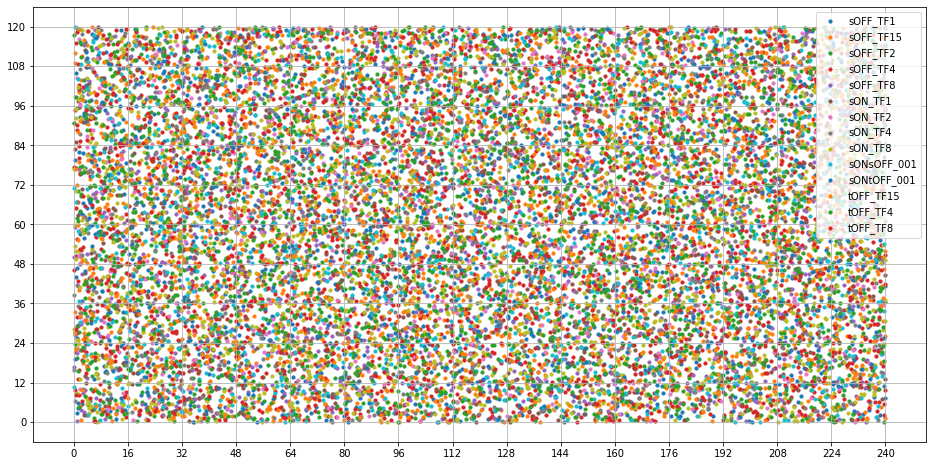

In [3]:
x_grids = 15
y_grids = 10
size = (240.0, 120.0)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for model_name, model_df in lgn_nodes_df.groupby('model_name'):
    ax.scatter(model_df['x'].values, model_df['y'].values, s=10, label=model_name)

ax.set_xticks(np.arange(0, size[0]+x_grids, size[0]/x_grids))
ax.set_yticks(np.arange(0, size[1]+y_grids, size[1]/y_grids))
ax.legend()
ax.grid()

#### FilterNet Config

We will start with a moving grating running at a 90 degree angle at a rate of 4 Hz, with a 500 ms grey-screen at the start. Update the ```config.simulation_filternet.dg_90deg_4Hz.json``` in the inputs sections:

```json
  "inputs": {
    "gratings": {
      "input_type": "movie",
      "module": "graiting",
      "row_size": 120,
      "col_size": 240,
      "gray_screen_dur": 500.0,
      "cpd": 0.04,
      "temporal_f": 4.0,
      "contrast": 0.8,
      "theta": 90.0,
      "evaluation_options": {
        "downsample": 1,
        "separable": true
      }
    }
  },
```

To make things easier, instead of saving the results into the **output/** directory, it will be saved into the **inputs/** directory. This is because we want to use these results as the inputs into our ```PointNet``` visual cortex model. 

Note that we are actually saving a couple of files; the *rates* file contains the raw firing rate traces for each individual LGN cell in hdf5 format. ```FilterNet``` uses these rates and a Poisson process to convert the time-dependent firing rates into spike trains and saves it in the *spikes_file* in SONATA format.

```json
   "output":{
     "log_file": "log.txt",
     "output_dir": "./inputs",
     "rates_h5": "rates.gratings.dg_90deg_4Hz.h5",
     "spikes_file": "spikes.gratings.dg_90deg_4Hz.h5",
     "spikes_file_csv": "spikes.gratings.dg_90deg_4Hz.csv"
   },
```

#### Running FilterNet simulation

We can generate gratings input to our lgn cells either through the command line, with access to MPI:

```bash
 $ mpirun -np <N> python run_filternet.py config.simulation_filternet.dg_90deg_4Hz.json
```

or, with some modifications to the script we can run it in the notebook

In [ ]:
from bmtk.simulator import filternet

configs = [
    # drifting gratings at 2 Hz
    'config.simulation_filternet.dg_0deg_2Hz.json',
    'config.simulation_filternet.dg_45deg_2Hz.json',
    'config.simulation_filternet.dg_90deg_2Hz.json',   
    # drifting gratings at 4 Hz
    'config.simulation_filternet.dg_0deg_4Hz.json',
    'config.simulation_filternet.dg_45deg_4Hz.json',
    'config.simulation_filternet.dg_90deg_4Hz.json',
    # Full Field flashes
    # 'config.simulation_filternet.flash_on.json',
    # 'config.simulation_filternet.flash_off.json'
]


for config_file in configs:
    print('Running {}'.format(config_file))
    config = filternet.Config.from_json(config_file)
    config.build_env()

    net = filternet.FilterNetwork.from_config(config)
    sim = filternet.FilterSimulator.from_config(config, net)
    sim.run()
    print(' ')

Running config.simulation_filternet.dg_0deg_2Hz.json
2022-07-14 22:55:27,427 [WARNING] Directory ./inputs already exists.
2022-07-14 22:55:27,428 [INFO] Created log file
2022-07-14 22:55:28,915 [INFO] Building cells.


Besides the spikes we generated, ```FilterNet``` also saved the raw firing rates such that we can see the simulated lgn responses to the stimulus:

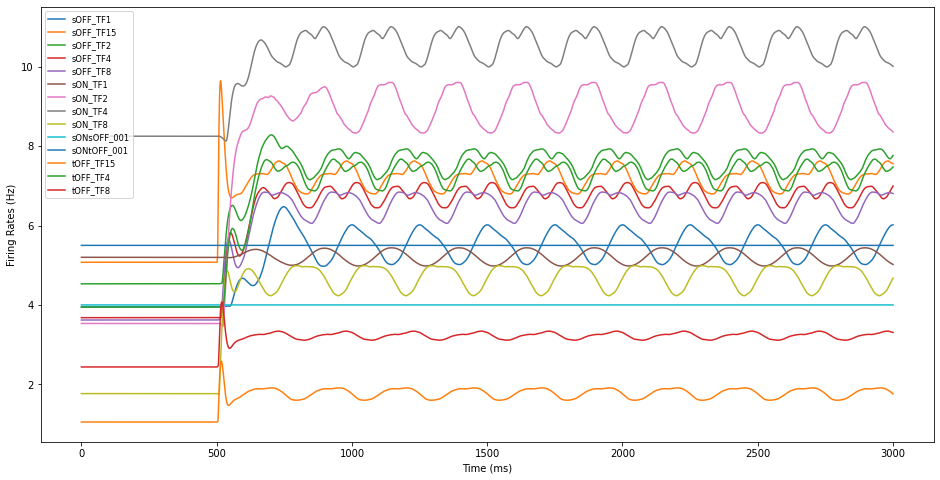

In [7]:
def plot_firing_rates(rates_file):
    net = sonata.File(
        data_files='network/lgn_nodes.h5',
        data_type_files='network/lgn_node_types.csv'
    )
    lgn_nodes_df = net.nodes['lgn'].to_dataframe(index_by_id=False)
    lgn_nodes_df = lgn_nodes_df[['node_id', 'model_name']]

    fig, axes = plt.subplots(1, 1, figsize=(16, 8))
    with h5py.File(rates_file, 'r') as h5:
        node_ids_lu = h5['/firing_rates/lgn/node_id'][()]
        firing_rates_hz = h5['/firing_rates/lgn/firing_rates_Hz']

        for model_name, model_df in lgn_nodes_df.groupby('model_name'):
            node_ids = model_df['node_id'].values
            node_ids_idx = node_ids_lu[node_ids]
            model_frs = firing_rates_hz[:, node_ids_idx]
            model_frs_avg = np.mean(model_frs, axis=1)
            axes.plot(model_frs_avg, label=model_name)

    axes.set_xlabel('Time (ms)')
    axes.set_ylabel('Firing Rates (Hz)')
    axes.legend(fontsize='small')
    plt.show()
    
plot_firing_rates('inputs/rates.gratings.90deg_4Hz.h5')

### BKG Inputs

For the non-thalamocortical background we will use a simple Poisson Process with a constant firing rate of 1 kHz.

In [8]:
psg = PoissonSpikeGenerator()
psg.add(node_ids='network/bkg_nodes.h5', firing_rate=1000.0, times=(0.0, 3.0), population='bkg')
psg.to_sonata('inputs/bkg_spikes.h5')

[**Return to the main chapter contents**](6.%20More%20Realistic%20Model%20and%20Advanced%20Features.ipynb)